In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [27]:
SEED = 42
# Set the global random seed
tf.random.set_seed(SEED)

# Paths and hyperparams
DATA_DIR = 'data'
IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE 

In [28]:
# load datasets from folders(train/val/test)
# Keras预处理效用函数
train_ds_orig =  tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'training'),
    labels = 'inferred',
    label_mode = 'binary', # 0/1. cats or dogs
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH,
    shuffle = True,
    seed = SEED
)

Found 9180 files belonging to 2 classes.


In [29]:
val_ds =  tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    labels = 'inferred',
    label_mode = 'binary', 
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH,
    shuffle = False
)

Found 1148 files belonging to 2 classes.


In [30]:
test_ds =  tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    labels = 'inferred',
    label_mode = 'binary', 
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH,
    shuffle = False
)

Found 1150 files belonging to 2 classes.


In [31]:
class_names = train_ds_orig.class_names
print('Classes:', class_names)

# MobileNet2 expects inputs in a specific range, use the built-in preprocess layer
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

# Performance: cache & prefetch 
train_ds = train_ds_orig.map(lambda x,y: (preprocess(x), y), num_parallel_calls = tf.data.AUTOTUNE).prefetch(AUTOTUNE)

val_ds = val_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls = tf.data.AUTOTUNE).prefetch(AUTOTUNE)

test_ds = test_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls = tf.data.AUTOTUNE).prefetch(AUTOTUNE)


# Base(pretrained on imageNet)
base = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)
base.trainable = False

Classes: ['cat', 'dog']


In [32]:
# Build the model
# inputs = tf.keras.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
# x = inputs
# x = base(x, training = False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

inputs = tf.keras.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
base_output = base(inputs, training = False)
pooling_output = tf.keras.layers.GlobalAveragePooling2D()(base_output)
drop_out = tf.keras.layers.Dropout(0.2)(pooling_output)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(drop_out)

model = tf.keras.Model(inputs, outputs, name = 'cats_dogs_mobilenetv2')
model.summary()

Model: "cats_dogs_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# Train the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [34]:
ckpt_path = 'best_model.keras'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        mode = 'max',
        monitor='val_accuracy',
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
]

In [35]:
# Train (start small: 5 - 10 epochs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
 95/287 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.8461 - loss: 0.3289

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


110/287 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.8586 - loss: 0.3082

163/287 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.8876 - loss: 0.2576

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


188/287 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.8967 - loss: 0.2408

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


243/287 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.9112 - loss: 0.2129

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 203ms/step - accuracy: 0.9197 - loss: 0.1961 - val_accuracy: 0.9817 - val_loss: 0.0539
Epoch 2/8
 99/287 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.9887 - loss: 0.0441

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


115/287 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.9886 - loss: 0.0437

170/287 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.9881 - loss: 0.0434

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


187/287 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.9880 - loss: 0.0433

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


271/287 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9875 - loss: 0.0430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 61s 214ms/step - accuracy: 0.9875 - loss: 0.0429 - val_accuracy: 0.9861 - val_loss: 0.0439
Epoch 3/8
100/287 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.9891 - loss: 0.0373

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


114/287 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.9890 - loss: 0.0370

172/287 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9888 - loss: 0.0365

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


200/287 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.9888 - loss: 0.0363

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


245/287 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9886 - loss: 0.0363

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 207ms/step - accuracy: 0.9885 - loss: 0.0362 - val_accuracy: 0.9869 - val_loss: 0.0426
Epoch 4/8
107/287 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9883 - loss: 0.0357

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


109/287 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9884 - loss: 0.0356

157/287 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.9885 - loss: 0.0347

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


189/287 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.9886 - loss: 0.0343

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/287 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9886 - loss: 0.0340

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 65s 228ms/step - accuracy: 0.9887 - loss: 0.0336 - val_accuracy: 0.9887 - val_loss: 0.0392
Epoch 5/8
103/287 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.9892 - loss: 0.0323

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


137/287 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9896 - loss: 0.0311

155/287 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.9897 - loss: 0.0308

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


188/287 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.9900 - loss: 0.0303

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


264/287 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9902 - loss: 0.0298

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 70s 242ms/step - accuracy: 0.9902 - loss: 0.0297 - val_accuracy: 0.9887 - val_loss: 0.0390
Epoch 6/8
 95/287 ━━━━━━━━━━━━━━━━━━━━ 43s 226ms/step - accuracy: 0.9923 - loss: 0.0254

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


117/287 ━━━━━━━━━━━━━━━━━━━━ 38s 229ms/step - accuracy: 0.9924 - loss: 0.0252

154/287 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.9924 - loss: 0.0251

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


210/287 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - accuracy: 0.9923 - loss: 0.0254

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


254/287 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.9921 - loss: 0.0256

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.9920 - loss: 0.0257 - val_accuracy: 0.9887 - val_loss: 0.0383
Epoch 7/8
 99/287 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.9922 - loss: 0.0245

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


108/287 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9923 - loss: 0.0245

161/287 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.9924 - loss: 0.0243

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


189/287 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.9924 - loss: 0.0243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


256/287 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9923 - loss: 0.0245

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/287 ━━━━━━━━━━━━━━━━━━━━ 84s 291ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9878 - val_loss: 0.0391


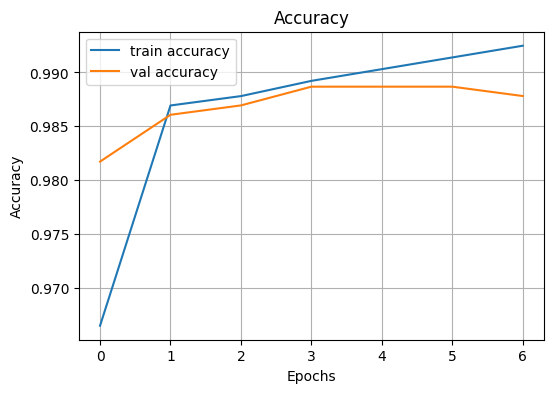

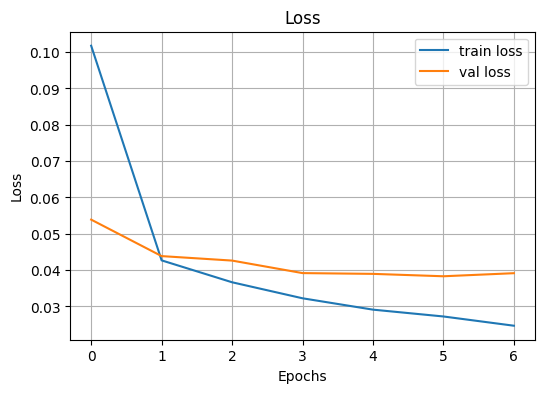

In [39]:
def plot_history(h, metric='accoracy'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(h.history[metric], label=f'train {metric}')
    plt.plot(h.history[f'val_{metric}'], label=f'val {metric}')
    plt.title(metric.capitalize())
    plt.xlabel('Epochs'); plt.ylabel(metric.capitalize()); plt.grid(True); plt.legend(); plt.show()
    
plot_history(history, 'accuracy')
plot_history(history, 'loss')

In [40]:
model = tf.keras.models.load_model('best_model.keras')
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test - accuracy: {test_acc:.4f}, loss: {test_loss:.4f}')

20/36 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9921 - loss: 0.0221

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9899 - loss: 0.0299
Test - accuracy: 0.9861, loss: 0.0374
